In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import os
import sys
from tqdm import tqdm, trange

from IPython.display import Image, display

import imageio
import cairosvg
import tempfile
import os
from IPython.display import Image, display

sys.path.append("../../")
import biked_commons
from biked_commons.rendering import rendering, animation

from biked_commons.data_loading import data_loading
from biked_commons.conditioning import conditioning
from biked_commons.design_evaluation import design_evaluation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Using java as the Java binary


c:\Users\Lyler\mambaforge\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = data_loading.load_bike_bench_train()

In [3]:
#get the minimum and maximum values for each column
# mean_values = torch.tensor(data.mean().values, device=device, dtype=torch.float32)
data_variance = torch.tensor(data.var().values, device=device, dtype=torch.float32)

In [4]:
# evaluators = [design_evaluation.AestheticsEvaluator(mode="Text", batch_size=64, device=device)]
evaluators = [design_evaluation.ErgonomicsEvaluator(device=device)]
evaluator, requirement_names, requirement_types = design_evaluation.construct_tensor_evaluator(evaluators, data.columns)
rider_condition = conditioning.sample_riders(1, split="test")
use_case_condition = conditioning.sample_use_case(1, split="test")
condition = {"Rider": rider_condition, "Use Case": use_case_condition}

In [5]:
data_gd = torch.tensor(data.iloc[1:2].values, dtype=torch.float32, device=device, requires_grad=True)

all_steps = [data_gd.detach().clone()]
for i in tqdm(range(1000)):
    loss = evaluator(data_gd, condition).sum()
    loss.backward()
    
    with torch.no_grad():
        data_gd -= 0.01 * data_gd.grad * data_variance #equivalent to gd on the normalized data
        # data_gd = torch.clamp(data_gd, min_values, max_values)
        

    data_gd.requires_grad_()
    data_gd.grad = None

    all_steps.append(data_gd.detach().clone())

all_steps_tensor = torch.stack(all_steps, dim=0).cpu()  # shape: (steps, 1, features)
steps_df = pd.DataFrame(all_steps_tensor.squeeze(1).numpy(), columns=data.columns)

100%|██████████| 1000/1000 [00:24<00:00, 41.53it/s]


In [6]:
steps_df

,CS textfield,BB textfield,Stack,Head angle,Head tube length textfield,Seat stay junction0,Seat tube length,Seat angle,DT Length,FORK0R,...,Handlebar style OHCLASS: 2,Stem kind OHCLASS: 0,Stem kind OHCLASS: 1,Stem kind OHCLASS: 2,Fork type OHCLASS: 0,Fork type OHCLASS: 1,Fork type OHCLASS: 2,Seat tube type OHCLASS: 0,Seat tube type OHCLASS: 1,Seat tube type OHCLASS: 2
0,796.940002,-3.0,363.410645,39.000000,181.199997,36.0,567.0,37.000000,1243.389038,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,796.940002,-3.0,366.360931,38.977974,182.407181,36.0,567.0,37.694019,1240.054443,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,796.940002,-3.0,369.295807,38.955532,183.619888,36.0,567.0,38.317616,1236.695923,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,796.940002,-3.0,372.207306,38.932648,184.839157,36.0,567.0,38.877827,1233.310425,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,796.940002,-3.0,375.087158,38.909298,186.065994,36.0,567.0,37.834560,1229.895142,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,796.940002,-3.0,690.986755,34.459358,289.505707,36.0,567.0,55.232262,839.143921,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
997,796.940002,-3.0,690.986755,34.459358,289.505707,36.0,567.0,55.232262,839.143921,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
998,796.940002,-3.0,690.986755,34.459358,289.505707,36.0,567.0,55.232262,839.143921,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
999,796.940002,-3.0,690.986755,34.459358,289.505707,36.0,567.0,55.232262,839.143921,45.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [7]:
steps_df[["FIRST color R_RGB", "FIRST color G_RGB", "FIRST color B_RGB"]]

,FIRST color R_RGB,FIRST color G_RGB,FIRST color B_RGB
0,0.0,0.0,102.0
1,0.0,0.0,102.0
2,0.0,0.0,102.0
3,0.0,0.0,102.0
4,0.0,0.0,102.0
...,...,...,...
996,0.0,0.0,102.0
997,0.0,0.0,102.0
998,0.0,0.0,102.0
999,0.0,0.0,102.0


In [8]:
steps_subset = steps_df.iloc[::50, :].reset_index(drop=True)
gif = animation.render_to_gif(steps_subset, gif_filename="ergonomics.gif", rider_description=rendering.RiderArguments(show_rider=True))

Starting BikeCAD server on port 8080...
BikeCAD server started on port 8080.


Rendering frames: 100%|██████████| 21/21 [01:44<00:00,  4.97s/it]


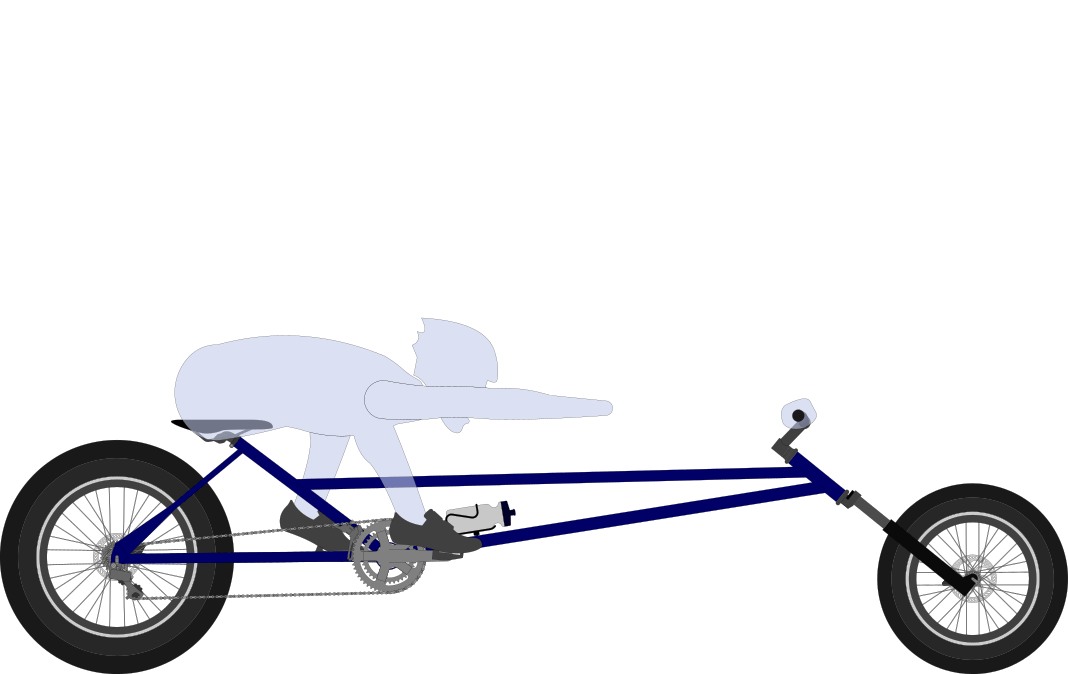

In [12]:
# To display in notebook
gif.seek(0)
display(Image(data=gif.read()))
